# 0. Introduction

*Author*: Pablo Fernández

## 0.1. Libraries

In [1]:
# !pip install pandarallel
# !pip install ipywidgets
# !pip install gensim

In [88]:
# Custom library
from hw1_library import metrics, preprocessing, regex_classifiers

# Utilities
import pandas as pd
import re  # For regex expressions
import collections  # For counting
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from pandarallel import pandarallel
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import pickle
import os
from tqdm import tqdm

# Basic NLP
from nltk.corpus import stopwords  # Stopwords list
from sklearn.feature_extraction.text import TfidfVectorizer

# Pre-trained embeddings
import gensim.downloader as api

# Deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dropout, LSTM, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

## 0.2. Data

**Dataset**: https://huggingface.co/datasets/rotten_tomatoes

### Data loading

In [3]:
splits = {'train': 'train.parquet', 'validation': 'validation.parquet', 'test': 'test.parquet'}

df_train = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["train"])

df_val = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["validation"])

df_test = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["test"])

df_dict = {
    "train": df_train,
    "validation": df_val,
    "test": df_test
}

### Basic EDA

In [4]:
df_train.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


Features (taken from the dataset's website):
- `text`: a string feature.
- `label`: a classification label, with possible values including *neg* (0, which stands for negative reviews), *pos* (1, which stands for positive reviews).

In [5]:
# Print the number of rows in each split
print("Number of rows in each split:")
for split, df in df_dict.items():
    print(f"{split}: {len(df)}")

Number of rows in each split:
train: 8530
validation: 1066
test: 1066


Below, we check how balanced is the data: what is the ratio of positive and negative reviews in each split?

In [6]:
# Print the proportion of positive and negative reviews in each split
print("Proportion of positive and negative reviews in each split:")
for split, df in df_dict.items():
    pos_count = len(df[df['label'] == 1])
    neg_count = len(df[df['label'] == 0])
    total_count = len(df)
    pos_proportion = pos_count / total_count
    neg_proportion = neg_count / total_count
    print(f"{split}: Positive: {pos_proportion:.2f}, Negative: {neg_proportion:.2f}")

Proportion of positive and negative reviews in each split:
train: Positive: 0.50, Negative: 0.50
validation: Positive: 0.50, Negative: 0.50
test: Positive: 0.50, Negative: 0.50


As can be seen above, the data is highly balanced in all of the splits.

Finally, how long are, on average, the reviews in each split?

In [7]:
for split, df in df_dict.items():
    
    # Compute the total length of each review per split
    if 'text_length' not in df.columns:
        df['text_length'] = df['text'].apply(lambda x: len(x.split()))
    
    # Compute the unique word count for each review
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))
    
    print(f"\nSummary statistics for {split} split:")
    print("--" * 40)

    print(df.describe())


Summary statistics for train split:
--------------------------------------------------------------------------------
             label  text_length  unique_word_count
count  8530.000000  8530.000000        8530.000000
mean      0.500000    20.992849          18.837515
std       0.500029     9.371094           7.822833
min       0.000000     1.000000           1.000000
25%       0.000000    14.000000          13.000000
50%       0.500000    20.000000          19.000000
75%       1.000000    27.000000          24.000000
max       1.000000    59.000000          45.000000

Summary statistics for validation split:
--------------------------------------------------------------------------------
             label  text_length  unique_word_count
count  1066.000000  1066.000000        1066.000000
mean      0.500000    20.997186          18.745779
std       0.500235     9.639950           7.967075
min       0.000000     1.000000           1.000000
25%       0.000000    14.000000          13.0

We can quickly observe that, overall, the included texts (reviews) are short in length (on average, of 21 words).

## 0.3. Submission Guidelines

- Document your code, analysis, and findings in a Jupyter notebook. 1 point on code quality/presentation of results.
- Include comments and markdown cells to explain your logic and interpretations at each step.
- Submit the notebook file via colab.

## 0.4. Configurable parameters

In [8]:
metric_avg = 'macro' # Either 'macro', 'micro' or 'weighted'

# 1. Part 1: Rule-based Analysis using regexes (2 points)

**Objective**: Utilize regexes to classify movie reviews as positive or negative based on predefined linguistic rules.

To do this, first we must get a basic idea of the most common words of positive and negative reviews. A basic approach to do this is shown below, where I tokenize the reviews depending on the type of review (positive - 1 or negative - 0). 

In [9]:
# We extract the text of the positive reviews and the text of the negative reviews as numpy arrays
pos_reviews = df_train[df_train["label"] == 1]["text"].values
neg_reviews = df_train[df_train["label"] == 0]["text"].values

print(pos_reviews[0:2])

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .'
 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .']


Note that below we do not remove digits, as in this case they might contain relevant information about the sentiment of the review.

In [10]:
my_stop_words = set(stopwords.words('english'))

# Tokenize the positive reviews (creates a 2-D list, where each list is a review)
pos_reviews_tokens = [preprocessing.lower_nostop(review, rm_stopwords=True, stopword_set=my_stop_words) for review in pos_reviews]
# Tokenize the negative reviews (creates a 2-D list, where each list is a review)
neg_reviews_tokens = [preprocessing.lower_nostop(review, rm_stopwords=True, stopword_set=my_stop_words) for review in neg_reviews]

print("Tokenized positive reviews:")
print(pos_reviews_tokens[0:2])
print("\nTokenized negative reviews:")
print(neg_reviews_tokens[0:2])

Tokenized positive reviews:
[['rock', 'destined', '21st', 'century', 'new', 'conan', 'going', 'make', 'splash', 'even', 'greater', 'arnold', 'schwarzenegger', 'jean', 'claud', 'van', 'damme', 'steven', 'segal'], ['gorgeously', 'elaborate', 'continuation', 'lord', 'rings', 'trilogy', 'huge', 'column', 'words', 'cannot', 'adequately', 'describe', 'co', 'writer', 'director', 'peter', 'jackson', 'expanded', 'vision', 'j', 'r', 'r', 'tolkien', 'middle', 'earth']]

Tokenized negative reviews:
[['simplistic', 'silly', 'tedious'], ['laddish', 'juvenile', 'teenage', 'boys', 'could', 'possibly', 'find', 'funny']]


In [11]:
# Flatten the lists of tokens
pos_reviews_flat = [token for review in pos_reviews_tokens for token in review]
neg_reviews_flat = [token for review in neg_reviews_tokens for token in review]

# Count the frequency of each token in the positive reviews
pos_counter = collections.Counter(pos_reviews_flat)
neg_counter = collections.Counter(neg_reviews_flat)

In [12]:
print("Positive review token counts (10 most common words):")
print(pos_counter.most_common(10))

print("\nNegative review token counts (10 most common words):")
print(neg_counter.most_common(10))

Positive review token counts (10 most common words):
[('film', 695), ('movie', 445), ('one', 288), ('like', 223), ('story', 197), ('good', 177), ('comedy', 167), ('well', 150), ('even', 146), ('funny', 144)]

Negative review token counts (10 most common words):
[('movie', 671), ('film', 563), ('like', 364), ('one', 310), ('story', 190), ('much', 179), ('bad', 176), ('time', 161), ('even', 161), ('good', 152)]


Note that, as seen above (section 0.2), negative reviews are, on average, of the same length of positive reviews (in the training, validation and test splits). Therefore, even if this rule-based analysis is a naive approach, it is reasonable to compare the most frequent words for each type of reviews.  

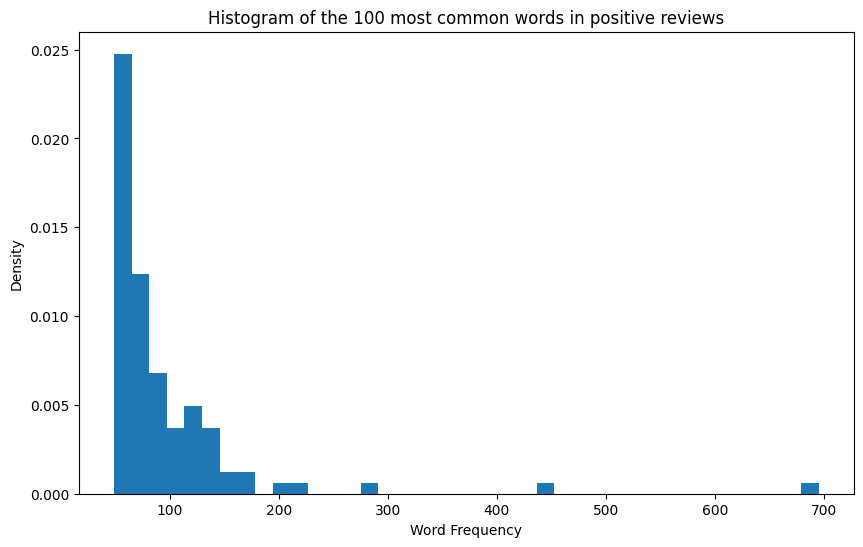

In [13]:
num_most_common = 100

# We get the frequency of the most common words in the positive reviews
pos_counter_most_common = pos_counter.most_common(num_most_common)

# Extract the words and frequency of the words of positive reviews
pos_common_words, pos_common_freq = zip(*pos_counter_most_common)

# Kernel density estimation
plt.figure(figsize=(10, 6))
plt.hist(pos_common_freq, bins=40, density=True)
plt.title(f"Histogram of the {num_most_common} most common words in positive reviews")
plt.xlabel("Word Frequency")
plt.ylabel("Density")
plt.show()

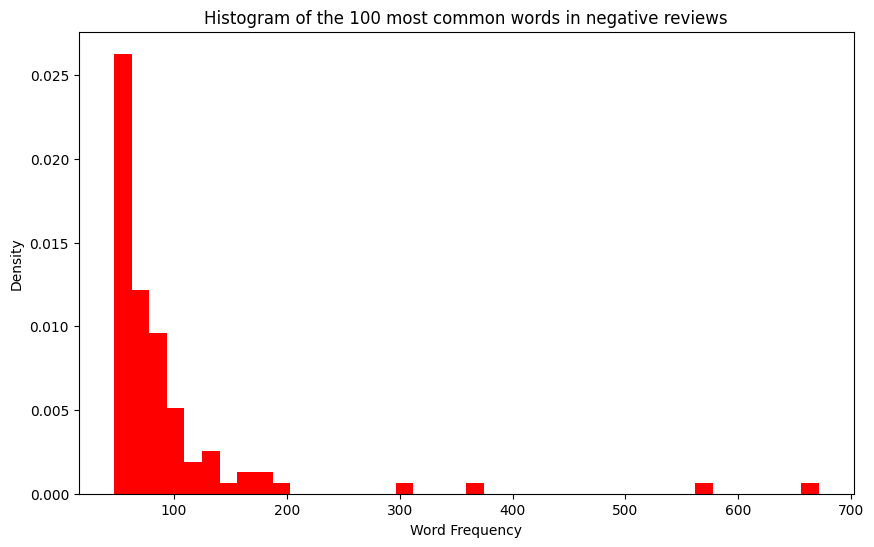

In [14]:
# We get the frequency of the most common words in the negative reviews
neg_counter_most_common = neg_counter.most_common(num_most_common)

# Extract the words and frequency of the words of negative reviews
neg_common_words, neg_common_freq = zip(*neg_counter_most_common)

# Kernel density estimation
plt.figure(figsize=(10, 6))
plt.hist(neg_common_freq, bins=40, density=True, color='red')
plt.title(f"Histogram of the {num_most_common} most common words in negative reviews")
plt.xlabel("Word Frequency")
plt.ylabel("Density")
plt.show()

As expected, there is a large difference between the words with the highest frequency and the common words but with lower frequency. However, we can observe a clear problem in the simple inspection of the word counts above: the most common words are the same for both type of reviews! To solve that, we can simply consider the words that are NOT in the other type of reviews, which will further refine the stopword removal and help us differentiate the reviews.

In [15]:
# Create set of common words for both positive and negative reviews
pos_common_words_set = set(pos_common_words)
neg_common_words_set = set(neg_common_words)

# Get the intersection of the two sets
common_words_set = pos_common_words_set.intersection(neg_common_words_set)

# Remove the intersection from the positive and negative common words
pos_common_words_set = pos_common_words_set - common_words_set
neg_common_words_set = neg_common_words_set - common_words_set

print("\nPositive common words (without intersection):")
print(pos_common_words_set)
print(f"Number of positive common words (without intersection): {len(pos_common_words_set)}")
print("\nNegative common words (without intersection):")
print(neg_common_words_set)
print(f"Number of negative common words (without intersection): {len(neg_common_words_set)}")


Positive common words (without intersection):
{'de', 'right', 'take', 'still', 'works', 'performance', 'ever', 'heart', 'performances', 'gives', 'often', 'family', 'entertaining', 'human', 'great', 'man', 'yet', 'compelling', 'worth', 'moving', 'cinema', 'world', 'fascinating', 'romantic', 'american', 'cast', 'seen', 'documentary', 'fun', 'part', 'tale', 'music'}
Number of positive common words (without intersection): 32

Negative common words (without intersection):
{'rather', 'dull', 'material', 'silly', 'thing', 'things', 'bad', 'quite', 'hard', 'another', 'comes', 'feels', 'nothing', 'despite', 'go', 'interesting', 'video', 'less', 'lot', 'dialogue', 'end', 'half', 'script', 'acting', 'tv', 'watching', 'seem', 'point', 'seems', 'minutes', 'ultimately', 'almost'}
Number of negative common words (without intersection): 32


## 1.1. Positive Reviews Rule Creation

(0.5 points): Develop a rule using regexes to identify phrases commonly found in positive reviews. Justify your choice of patterns.

Below, we use a simple rule where, if one of the words of the set of positive reviews created above appears in a review, it will be classified as a positive review, otherwise it will be classified as a negative review.

In [ ]:
# We create a regex pattern to match the common words of positive reviews:
# it captures ANY of the words in the set created above and ignores the case
pattern = re.compile(r"(" + "|".join(pos_common_words_set) + r")", re.IGNORECASE)

# Extract the true labels of the validation set
y_val_true = df_val["label"].to_list()

# For each review, make the predictions using the regex classifier
y_val_pred_pos_match = [regex_classifiers.regex_classifier(review, pattern, match_label=1) for review in df_val["text"].values]

print(y_val_true[0:5])
print(y_val_pred_pos_match[0:5])

[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]


In [ ]:
# Inspect the text of the first 5 predictions of the validation set
for i in range(5):
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_pos_match[i]}")
    print("-" * 80)

Review: compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .
True label: 1, Predicted label: 0
--------------------------------------------------------------------------------
Review: the soundtrack alone is worth the price of admission .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: beneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: bielinsky is a filmmaker of imp

Prediction errors:
- In the first review, the pattern is finding `seem` in `seemingly`, which is included as part of the set of words of negative reviews. This triggers a false negative.
- In the third review, it is apparently matching `end` (in the set of words of negative reviews) with `trend`, which creates a false negative.

In [ ]:
metrics_val = metrics.Metrics()

metrics_val.run(
    y_true=y_val_true,
    y_pred=y_val_pred_pos_match,
    method_name="Regex (Positive)",
    average=metric_avg
)

metrics_val.print_results()

Metrics calculated for: Regex (Positive)

Metrics for Regex (Positive)

Accuracy: 55.82%

Precision: 56.38%

Recall: 55.82%

F1 Score: 54.81%


This baseline classifier that detects positive reviews:
- Creates several false positives, which leads to an accuracy and precision which are only slightly better than random guessing.
- Is not very good at detecting positive instances, which leads to a relatively low recall (true positive predictions over all positive instances). 

## 1.2. Negative Reviews Rule Creation 

(0.5 points): Create a similar rule for detecting negative reviews. Explain the rationale behind the patterns selected.

In [ ]:
# We create a regex pattern to match the common words of negative reviews:
# it captures ANY of the words in the set created above and ignores the case
pattern = re.compile(r"(" + "|".join(neg_common_words_set) + r")", re.IGNORECASE)

# Extract the true labels of the validation set
y_val_true = df_val["label"].values

# For each review, make the predictions using the regex classifier
y_val_pred_neg_match = [regex_classifiers.regex_classifier(review, pattern, match_label=0) for review in df_val["text"].values]

print(y_val_true[0:5])
print(y_val_pred_neg_match[0:5])

[1 1 1 1 1]
[0, 1, 0, 1, 1]


In [ ]:
# Inspect the text of the first 5 predictions of the validation set
for i in range(5):
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_neg_match[i]}")
    print("-" * 80)

Review: compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .
True label: 1, Predicted label: 0
--------------------------------------------------------------------------------
Review: the soundtrack alone is worth the price of admission .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .
True label: 1, Predicted label: 0
--------------------------------------------------------------------------------
Review: beneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: bielinsky is a filmmaker of imp

In [ ]:
metrics_val.run(
    y_true=y_val_true,
    y_pred=y_val_pred_neg_match,
    method_name="Regex (Negative)",
    average=metric_avg
)

metrics_val.print_results()

Metrics calculated for: Regex (Negative)

Metrics for Regex (Positive)

Accuracy: 55.82%

Precision: 56.38%

Recall: 55.82%

F1 Score: 54.81%

Metrics for Regex (Negative)

Accuracy: 57.41%

Precision: 57.47%

Recall: 57.41%

F1 Score: 57.33%


Compared to the positive reviews detection, this rule-based system of detecting negative reviews is performing relatively better, over all metrics. This might denote that the **most common words of negative reviews used is more different than the most common words of positive reviews**. 

## 1.3. Reducing False Positives 

(1 point): Propose and implement a rule to minimize false positives in your classifications. Discuss the improvements observed.

In [ ]:
y_val_true = df_val["label"].to_list()

# Let's identify the false positives and negatives for positive match
fp_indices_pos_match = []  # Predicted positive but actually negative
fn_indices_pos_match = []  # Predicted negative but actually positive

print("False Positives and Negatives for Regex Baseline (Positive Match):")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred_pos_match)):
    if true == 0 and pred == 1:
        fp_indices_pos_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_pos_match.append(i)

print("False Positives:", len(fp_indices_pos_match), "examples")
print("False Negatives:", len(fn_indices_pos_match), "examples")

# Print the first 5 false positives
print("\nFalse Positives (Regex Baseline - Positive Match):")
for i in fp_indices_pos_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_pos_match[i]}")
    print("-" * 80)

# Print the first 5 false negatives
print("\nFalse Negatives (Regex Baseline - Positive Match):")
for i in fn_indices_pos_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_pos_match[i]}")
    print("-" * 80)

False Positives and Negatives for Regex Baseline (Positive Match):
-----------------------------------------------------
False Positives: 315 examples
False Negatives: 156 examples

False Positives (Regex Baseline - Positive Match):
Review: bogs down badly as we absorb jia's moody , bad-boy behavior which he portrays himself in a one-note performance .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: the camera whirls ! the camera twirls ! oh , look at that clever angle ! wow , a jump cut !
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: demme finally succeeds in diminishing his stature from oscar-winning master to lowly studio hack .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: it almost feels as if the movie is more interested in entertaining itself than in amu

In [ ]:
y_val_true = df_val["label"].to_list()

# Let's identify the false positives and negatives for negative match
fp_indices_neg_match = []  # Predicted positive but actually negative
fn_indices_neg_match = []  # Predicted negative but actually positive

print("False Positives and Negatives for Regex Baseline (Negative Match):")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred_neg_match)):
    if true == 0 and pred == 1:
        fp_indices_neg_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_neg_match.append(i)

print("False Positives:", len(fp_indices_neg_match), "examples")
print("False Negatives:", len(fn_indices_neg_match), "examples")

# Print the first 5 false positives
print("\nFalse Positives (Regex Baseline - Negative Match):")
for i in fp_indices_neg_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_neg_match[i]}")
    print("-" * 80)

# Print the first 5 false negatives
print("\nFalse Negatives (Regex Baseline - Negative Match):")
for i in fn_indices_neg_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_neg_match[i]}")
    print("-" * 80)

False Positives and Negatives for Regex Baseline (Negative Match):
-----------------------------------------------------
False Positives: 250 examples
False Negatives: 204 examples

False Positives (Regex Baseline - Negative Match):
Review: the camera whirls ! the camera twirls ! oh , look at that clever angle ! wow , a jump cut !
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: demme finally succeeds in diminishing his stature from oscar-winning master to lowly studio hack .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: it puts washington , as honest working man john q . archibald , on a pedestal , then keeps lifting the pedestal higher .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: far more enjoyable than its predecessor .
True label: 0, Predicted label: 1
--

Note that of the first 5 false positives for both types of matching, there are 3 reviews that appear in both cases, which can reveal that both types of matching are failing in the same cases.

In [24]:
# Check the number of false positive reviews that match for both types of matching
fp_both = set(fp_indices_pos_match).intersection(set(fp_indices_neg_match))
print(f"Number of false positive reviews that match for both types of matching: {len(fp_both)}")

# Check the number of false negative reviews that match for both types of matching
fn_both = set(fn_indices_pos_match).intersection(set(fn_indices_neg_match))
print(f"Number of false negative reviews that match for both types of matching: {len(fn_both)}")

Number of false positive reviews that match for both types of matching: 130
Number of false negative reviews that match for both types of matching: 50


For the positive matching rule, almost half of its false positives match with the false positives of the negative match (for which more than half coincide). These cases will probably be hard cases, since neither of the patterns can pick them up correctly.

Below we try to reduce the number of false positives **for the positive matching** by extending the regex list with those words appearing in the false positive instances but NOT as much on actually positive instances of the test set. Then, we will check the metrics before and after the pattern extension for the test set.

In [ ]:
# Get the indices for the positive predictions with the positive match
positive_indices = []
for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred_pos_match)):
    if true == 1:
        positive_indices.append(i)

# Subset the false positive reviews and the false negative reviews
fp_reviews = df_val.iloc[fp_indices_pos_match]['text'].values
# fn_reviews = df_val.iloc[fn_indices_pos_match]['text'].values
pos_pred_reviews = df_val.iloc[positive_indices]['text'].values 

# Tokenize the false positive and false negative reviews
fp_tokens = [preprocessing.lower_nostop(review, rm_stopwords=True, stopword_set=my_stop_words) for review in fp_reviews]
# fn_tokens = [tokenize(review, rm_stopwords=True, stopword_set=my_stop_words) for review in fn_reviews]
pos_pred_tokens = [preprocessing.lower_nostop(review, rm_stopwords=True, stopword_set=my_stop_words) for review in pos_pred_reviews]

# Flatten the lists of tokens
fp_reviews_flat = [token for review in fp_tokens for token in review]
# fn_reviews_flat = [token for review in fn_tokens for token in review]
pos_pred_reviews_flat = [token for review in pos_pred_tokens for token in review]

# Count the frequency of each token in the false positive and false negative reviews
fp_counter = collections.Counter(fp_reviews_flat)
# fn_counter = collections.Counter(fn_reviews_flat)
pos_pred_counter = collections.Counter(pos_pred_reviews_flat)

In [26]:
# Set minimum word frequency to filter out rare words
min_word_freq = 4

# Let's create a ratio of occurences in the false positives over all of the positive instances
# A value of 1 means that the word appears only in the false positives
fp_ratio = {word: fp_counter.get(word, 0) / (fp_counter.get(word, 0) + pos_pred_counter.get(word, 0)) 
            for word in fp_counter if fp_counter.get(word, 0) + pos_pred_counter.get(word, 0) > min_word_freq}

#Let's sort the words by the ratio
fp_ratio = sorted(fp_ratio.items(), key=lambda x: x[1], reverse=True)

# Let's print the words that appear a lot in the false positives but not so much in the false negatives
for word, ratio in fp_ratio[:30]:
    print(word, ratio)

running 1.0
dull 1.0
minutes 0.9
idea 0.8888888888888888
ending 0.8571428571428571
sandler 0.8571428571428571
wrong 0.8333333333333334
joke 0.8333333333333334
cut 0.8
play 0.8
predictable 0.8
silly 0.8
scene 0.8
beyond 0.8
talent 0.8
science 0.8
teen 0.8
level 0.8
sure 0.8
george 0.8
energy 0.75
bad 0.7222222222222222
every 0.7142857142857143
lacks 0.7142857142857143
looking 0.7142857142857143
together 0.7
mind 0.6666666666666666
fine 0.6666666666666666
simply 0.6666666666666666
nearly 0.6666666666666666


These words should be considered to detect negative reviews instead of positive reviews. To that end, below we extend the regex classification function to consider that, whenever a review contains more of the positive words than of the negative words of the false positive list identified above, it will be classified as positive, otherwise as negative.

In [27]:
# We create a regex pattern to match the common words of positive reviews:
# it captures ANY of the words in the set created above and ignores the case
pattern_pos = re.compile(r"(" + "|".join(pos_common_words_set) + r")", re.IGNORECASE)
pattern_neg = re.compile(r"(" + "|".join(neg_common_words_set) + r")", re.IGNORECASE)

# Extract the true labels of the validation set
y_test_true = df_test["label"].to_list()

Now, we use the classifier and compute the metrics for the test set, both with the initial pattern and with the extended pattern.

Initial pattern:

In [28]:
# For each review, make the predictions using the regex classifier
y_test_pred_pos_match = [regex_classifiers.regex_classifier(review, pattern_pos, match_label=1) for review in df_test["text"].values]
# Compute the metrics for the baseline model and the test set
metrics_test = metrics.Metrics()
metrics_test.run(
    y_true=y_test_true,
    y_pred=y_test_pred_pos_match,
    method_name="Regex (Positive)",
    average=metric_avg
)
metrics_test.print_results()

# Let's identify the false positives and negatives for positive match
fp_indices_pos_match = []  # Predicted positive but actually negative
fn_indices_pos_match = []  # Predicted negative but actually positive

print("\nFalse Positives and Negatives for Regex Baseline (Positive Match), Test set:")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_test_true, y_test_pred_pos_match)):
    if true == 0 and pred == 1:
        fp_indices_pos_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_pos_match.append(i)

print("False Positives:", len(fp_indices_pos_match), "examples")
print("False Negatives:", len(fn_indices_pos_match), "examples")

Metrics calculated for: Regex (Positive)

Metrics for Regex (Positive)

Accuracy: 52.72%

Precision: 52.90%

Recall: 52.72%

F1 Score: 51.96%

False Positives and Negatives for Regex Baseline (Positive Match), Test set:
-----------------------------------------------------
False Positives: 319 examples
False Negatives: 185 examples


Extended pattern:

In [29]:
# Set a threshold for the ratio of words in FP and not in positive reviews (1 for words that appear only in false positives and not in actual positives)
threshold = 0.6

# Filter the words based on the threshold
fp_ratio_threshold = [(word, ratio) for word, ratio in fp_ratio if ratio >= threshold]

# Extract the words and ratio of the words of false positives
fp_words, fp_ratio_value = zip(*fp_ratio_threshold)

# Create a set of the words
fp_words_set = set(fp_words)

# Create a regex pattern to match the common words of false positives
pattern_fp = re.compile(r"(" + "|".join(fp_words_set) + r")", re.IGNORECASE)

# For each review, make the predictions using the regex classifier
y_test_pred_ext = [regex_classifiers.regex_classifier_ext(review, pattern_pos, pattern_fp) for review in df_test["text"].values]
metrics_test.run(
    y_true=y_test_true,
    y_pred=y_test_pred_ext,
    method_name="Regex - Extended",
    average=metric_avg
)
metrics_test.print_results()

# Let's identify the false positives and negatives for positive match
fp_indices_pos_match = []  # Predicted positive but actually negative
fn_indices_pos_match = []  # Predicted negative but actually positive

print("\nFalse Positives and Negatives for Regex Baseline (Positive Match), Test set:")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_test_true, y_test_pred_ext)):
    if true == 0 and pred == 1:
        fp_indices_pos_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_pos_match.append(i)

print("False Positives:", len(fp_indices_pos_match), "examples")
print("False Negatives:", len(fn_indices_pos_match), "examples")

Metrics calculated for: Regex - Extended

Metrics for Regex (Positive)

Accuracy: 52.72%

Precision: 52.90%

Recall: 52.72%

F1 Score: 51.96%

Metrics for Regex - Extended

Accuracy: 55.72%

Precision: 55.81%

Recall: 55.72%

F1 Score: 55.55%

False Positives and Negatives for Regex Baseline (Positive Match), Test set:
-----------------------------------------------------
False Positives: 203 examples
False Negatives: 269 examples


There is something interesting to note here, but that is expected: lowering the threshold for the ratio of words of false positives in the validation set decreases the number of false positives. This can be attributed mainly to the fact that the search for words typically in negative reviews will be extended, and thus it will be more possible that a review is not incorrectly classified as positive. However, this leads to an increase in the number of false negatives.

Finally, **note that the performance of this approach could be potentially improved by handpicking those words which make sense for each type of review**, and selecting those which make more (intuitive) sense to include for each label.

# 2. Part 2: Machine Learning with TF-IDF and Logistic Regression (3 points)

**Objective**: Build and evaluate a sentiment analysis model using TF-IDF vectorization and logistic regression.

## 2.1. Model Fitting 

(0.5 points): Train a logistic regression model on TF-IDF vectors of the movie reviews.

We start by training with a baseline pipeline, which below will be extended to different pre-processing techniques to improve performance.

Document-term matrix for train has size (documents, terms) (8530, 16188)
Document-term matrix for validation has size (documents, terms) (1066, 16188)
Metrics calculated for: Logreg - TFIDF


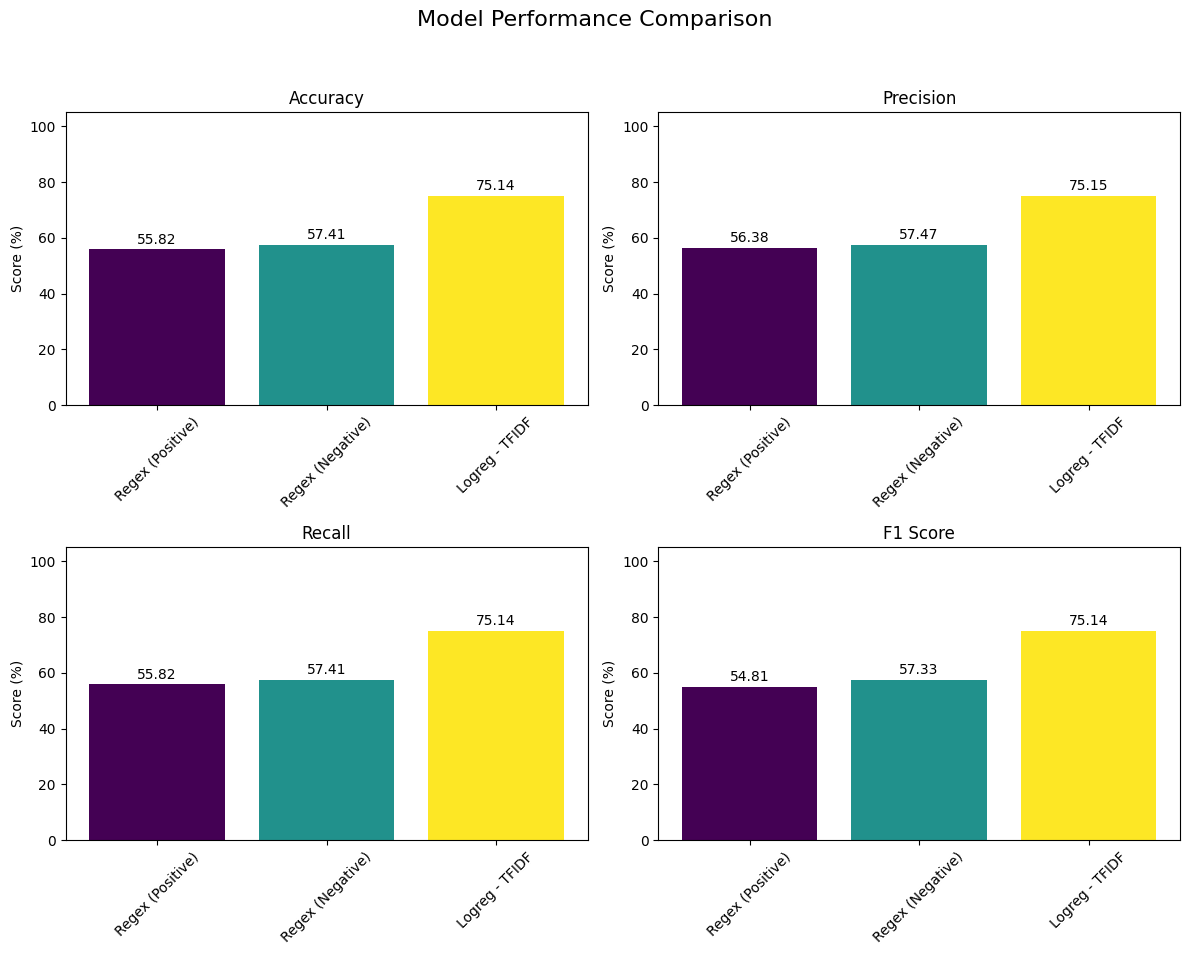

In [30]:
# Construct the tf-idf vectorizer with the default parameters and stop words for English
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    lowercase=True,
    min_df=0.0,
    max_df=1.0,
    sublinear_tf=True  # Apply sublinear term frequency scaling (i.e., log normalization to compress the range of term frequencies)
)

# Fit to the training data 
tfidf_vectorizer.fit(df_train['text'].values)

# Transform the training and validation data (creates the document-term matrix)
X_train = tfidf_vectorizer.transform(df_train['text'].values)
X_valid = tfidf_vectorizer.transform(df_val['text'].values)

for split, dtm in {'train': X_train, 'validation': X_valid}.items():
    print(f"Document-term matrix for {split} has size (documents, terms) {dtm.shape}")

# Create the Logistic Regression model
logistic_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='liblinear',  # Small dataset, binary classification
    random_state=42
)

# Fit the model to the training data
logistic_model.fit(X_train, df_train['label'].values)

# Make predictions on the validation set
valid_preds = logistic_model.predict(X_valid)

# Compute the metrics for the logistic regression model and the validation set
metrics_val.run(
    y_true=df_val['label'].values,
    y_pred=valid_preds,
    method_name="Logreg - TFIDF",
    average=metric_avg
)

metrics_val.plot()

Without almost any preprocessing (just stopword removal and lowercasing, but no further text preprocessing or hyperparameter optimization) the performance is already significantly better than for the regex classifiers.

## 2.2. Feature Importance Analysis

(0.5 points): Identify and interpret the most influential features in your model.

For analyzing the importance of features (in this case, uni-grams) of the logistic regression model, it must be considered that through TF-IDF the term frequency of the documents has been normalized, so the magnitude of the coefficients in the logistic regression can be used to infer relative feature importance. Specifically:
- The sign of the coefficient indicates the direction of influence (positive, 1 vs. negative, 0 sentiment).
- Larger magnitude generally indicates stronger influence on the prediction.
- Ranking features by coefficient magnitude can identify the most important terms.

In [31]:
# First of all, we extract the words from the fitted DTM
terms = tfidf_vectorizer.get_feature_names_out()

# Extract the coefficients of the logistic regression model
coefs = logistic_model.coef_[0]
print(f'Number of coefficients (should match the number of terms in the training set): {coefs.shape}')

# Extract the top 20 positive and negative coefficients
top_n = 20
top_positive_indices = coefs.argsort()[-top_n:][::-1]  # Indices of the top positive coefficients
top_negative_indices = coefs.argsort()[:top_n]  # Indices of the top negative coefficients

# Print the values of the top positive and negative coefficients to check
print("\nTop positive coefficients:\n")
for i in top_positive_indices:
    print(f"Word: {terms[i]}, Coefficient: {coefs[i]}")
print("\nTop negative coefficients:\n")
for i in top_negative_indices:
    print(f"Word: {terms[i]}, Coefficient: {coefs[i]}")

Number of coefficients (should match the number of terms in the training set): (16188,)

Top positive coefficients:

Word: performances, Coefficient: 2.7513229113981668
Word: enjoyable, Coefficient: 2.174851585066445
Word: cinema, Coefficient: 2.1018280976138297
Word: fun, Coefficient: 2.1009884855582883
Word: beautiful, Coefficient: 2.0774950625881714
Word: solid, Coefficient: 2.0388579766963693
Word: culture, Coefficient: 2.010448144921942
Word: entertaining, Coefficient: 1.9945226910050151
Word: best, Coefficient: 1.9603469963567457
Word: powerful, Coefficient: 1.9372810730634509
Word: wonderful, Coefficient: 1.932985816143211
Word: hilarious, Coefficient: 1.9315420837891548
Word: engrossing, Coefficient: 1.9295295968304995
Word: touching, Coefficient: 1.926475652197013
Word: heart, Coefficient: 1.9074218792035402
Word: portrait, Coefficient: 1.9024987434537053
Word: human, Coefficient: 1.842652818949533
Word: moving, Coefficient: 1.8361015523468038
Word: rare, Coefficient: 1.819374

As expected, the words with the highest relevance for predicting a review as positive are also positive words, such as "enjoyable", "best", "wonderful", etc.; while for negative reviews it is the opposite: words such as "boring", "feels", "flat", etc. are the most relevant. In terms of values, these coefficients are not directly interpretable (they are logit values, not probabilities or percentage points).

## 2.3. Preprocessing Improvements

(1 point): Experiment with different preprocessing techniques of your training set to enhance model performance. Summarize the impact of these modifications.

Compared to the baseline model implemented above, several improvements (or at least possibilities) can be executed:
1) More customized text pre-processing (e.g., lemmatization).
2) Considering different parameters for the tf-idf vectorizer, such as higher n-gram inclusion and minimum document-frequency or maximum document-frequency parameters.
3) Considering different parameters for the logistic regression (e.g., regularization parameter, penalization type, maximum iterations).

In [32]:
# Initialize parallelization for pandas
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Text preprocessing

In this section, different types of text features are constructed. Lemmatized and stemmed words are expected to reduce the length of the vocabulary. 

In [33]:
# First, we preprocess the text of the reviews with the custom functions

my_stop_words = set(stopwords.words('english'))

for split, df in df_dict.items():
    print(f"\nPreprocessing {split} split...")
    df['text_lower'] = df['text'].parallel_apply(
        lambda row: preprocessing.lower_nostop(text = row, rm_stopwords=True, stopword_set=my_stop_words, output_type='string')
    )
    df['text_lemmatized'] = df['text_lower'].parallel_apply(
        lambda row: preprocessing.lemmatize(row)
    )
    df['text_stemmed'] = df['text_lower'].parallel_apply(
        lambda row: preprocessing.stem(row)
    )
    print(f"Preprocessing {split} split done.")


Preprocessing train split...


Preprocessing train split done.

Preprocessing validation split...


Preprocessing validation split done.

Preprocessing test split...


Preprocessing test split done.


In [34]:
df_train.head()

,text,label,text_length,unique_word_count,text_lower,text_lemmatized,text_stemmed
0,the rock is destined to be the 21st century's ...,1,34,31,rock destined 21st century new conan going mak...,rock destined 21st century new conan going mak...,rock destin 21st centuri new conan go make spl...
1,"the gorgeously elaborate continuation of "" the...",1,39,29,gorgeously elaborate continuation lord rings t...,gorgeously elaborate continuation lord ring tr...,gorgeous elabor continu lord ring trilog huge ...
2,effective but too-tepid biopic,1,4,4,effective tepid biopic,effective tepid biopic,effect tepid biopic
3,if you sometimes like to go to the movies to h...,1,21,18,sometimes like go movies fun wasabi good place...,sometimes like go movie fun wasabi good place ...,sometim like go movi fun wasabi good place start
4,"emerges as something rare , an issue movie tha...",1,21,21,emerges something rare issue movie honest keen...,emerges something rare issue movie honest keen...,emerg someth rare issu movi honest keenli obse...


As can be observed in the previous data frame, lemmatizing does not significantly change the wording of the tokens, while stemming is generally more aggressive in reducing the vocabulary length (at the cost of reducing interprebatility).

### Hyperparameter optimization: TF-IDF and logistic regression

In [35]:
# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=False,  # We have already lowercased the text
        stop_words=None,  # We have already removed stop words
        sublinear_tf=True,  # Apply sublinear term frequency scaling
        )
    ),
    ('clf', LogisticRegression(
        max_iter=5000,
        class_weight=None,
        fit_intercept=True,
        solver='liblinear',
        random_state=42
        )
    )
])

# Define the parameter grid for the randomized search
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams, bigrams and trigrams
    'tfidf__min_df': uniform(loc=0.0, scale=0.1),  # Minimum document frequency, uniform distribution from 0% to 10%
    'tfidf__max_df': uniform(loc=0.8, scale=0.2),  # Maximum document frequency, uniform distribution from 80% to 100%
    'clf__C': uniform(loc=0.01, scale=10),  # Regularization strength, uniform distribution from 0.01 to 10
    'clf__penalty': ['l1', 'l2']  # Regularization type
}

# Create the randomized search object
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=500,  # Number of iterations for the randomized search
    scoring=f'f1_{metric_avg}', # Use the F1-score averaged as specified
    cv=5,  # 5-fold cross-validation with stratification
    refit=f'f1_{metric_avg}',  # Refit the best model with the F1-score averaged as specified
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

In [36]:
preprocessed_text = 'text_lower'  # Choose the preprocessed text to use for the model

In [37]:
# # Fit the randomized search on the training data, 
# random_search.fit(df_train[preprocessed_text].values, df_train['label'].values)

# # Best parameters found by grid search
# print(f'Best Parameters: {random_search.best_params_}')

# # Save the best model as a pickle file with the name of the model and the F1 score in the models directory
# os.makedirs('models', exist_ok=True)
# best_model_name = f"models/logreg_tfidf_f1_{metric_avg}_{random_search.best_score_:.4f}_{preprocessed_text}.pkl"
# with open(best_model_name, 'wb') as f:
#     pickle.dump(random_search.best_estimator_, f)
# print(f"Best model saved as: {best_model_name}")

With 500 iterations and 5 folds per iteration, the code above approximately takes 30 seconds to run. 

In [38]:
# Load the best model from the pickle file
with open('models/logreg_tfidf_f1_macro_0.7463_text_lower.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Train the best model on the entire training set
model = best_model.fit(df_train[preprocessed_text].values, df_train['label'].values)

model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=0.8924194581531322,
                                 min_df=0.00012318351664258875,
                                 ngram_range=(1, 3), sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=6.176503145207381, max_iter=5000,
                                    random_state=42, solver='liblinear'))])

The question is: has the model been improved in the validation set?

Metrics calculated for: Logreg - best TFIDF


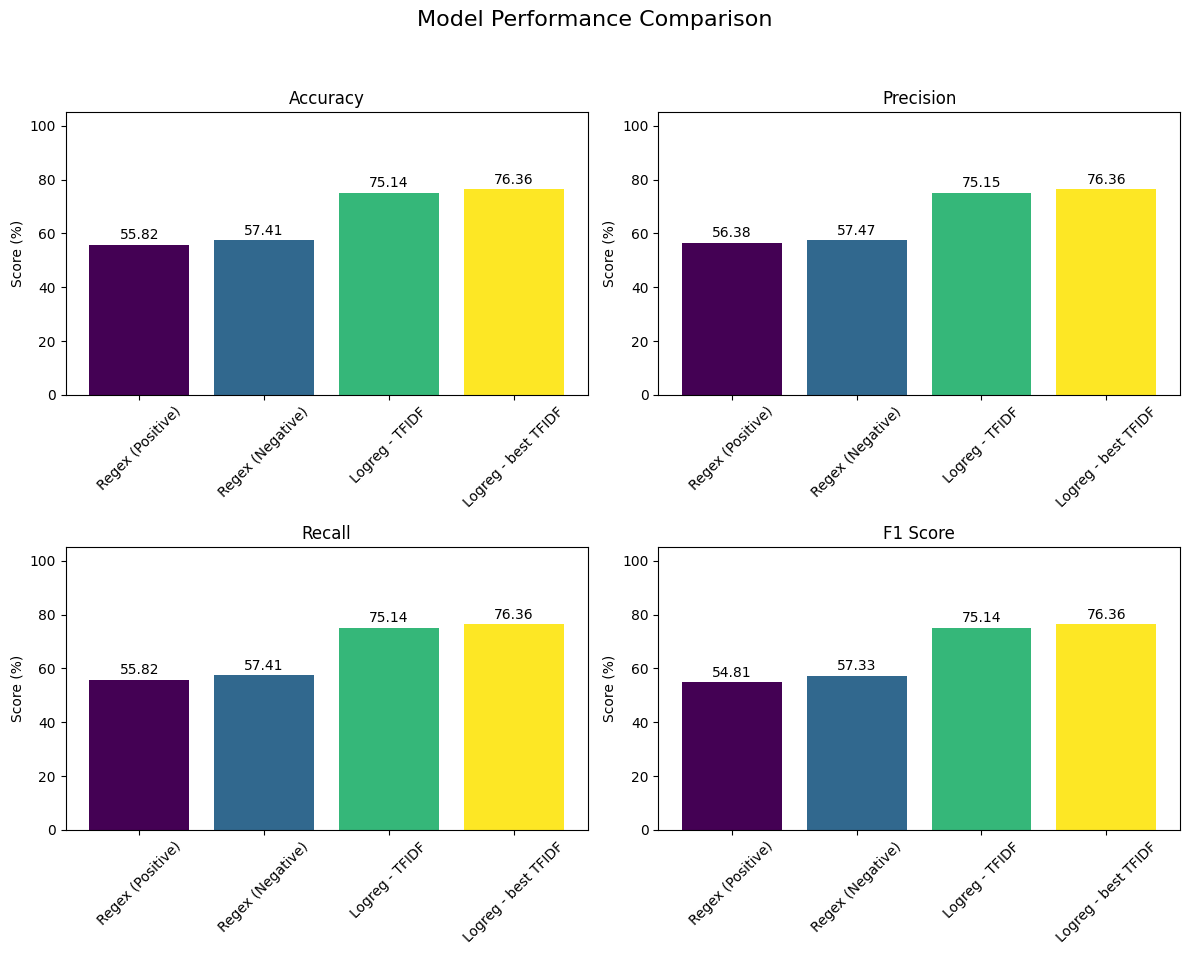

In [39]:
# Evaluate on the validation set
valid_preds = best_model.predict(df_val[preprocessed_text].values)

# Compute the metrics for the logistic regression model and the validation set
metrics_val.run(
    y_true=df_val['label'].values,
    y_pred=valid_preds,
    method_name="Logreg - best TFIDF",
    average=metric_avg
)

metrics_val.plot()

According to the plot shown above, it can be observed that hyperparameter-tuning has only slightly improved the performance of the sentiment detection model over the logistic regression default parameters. 
- Other text preprocessing techniques have also been tried out as features (stemmed features, lemmatized features), but in these cases the performance has been observed to be worse. The most possible reason to explain that is that the vocabulary reduction and simplification associated to lemmatizing and stemming does not come with a better performance, even if the dimensionality of the features are reduced. In other words, in this case the nuances from the default text (with only lowercasing and stopword removal) are worth keeping (at least with literal NLP techniques). Nevertheless, the performance is very similar for the three types of preprocessing.
- In the optimal model, the minimum document frequency (`min_df`, a threshold that can be set between a [0.0, 1.0] which denotes which terms to ignore if a word appears in less than x% of the reviews) is extremely low, close to 0%. This is relatively expected in the sense that less words of the review corpus are pruned, thus keeping more information.
- Something similar happens with the maximum document frequency (`max_df`, words appearing in more than x% of the reviews are pruned), which is set at a relatively high value (close to 90%). Therefore, approximately 10% of the most common words across documents are ignored in the final model.
- Finally, and probably to preserve the maximum "context" as possible, the best scores are found with the inclusion of **uni-grams, bi-grams and tri-grams**, which can be seen as an attempt to overcome the limitations of literality of TF-IDF.

In conclusion, even if performance has been increased, the main limitation is still present: **this method cannot capture, at all, context from the reviews**.

## 2.4. Word2Vec Embeddings 

(0.5 points each for a. and b.)

Below, the [pre-trained Word2Vec embeddings from `gensim`](https://radimrehurek.com/gensim/models/word2vec.html) are used (information on their Word2Vec training utilities can be found [here](https://radimrehurek.com/gensim/models/word2vec.html)). Specifically, the model loaded is the one trained on the Google News data, which has 3 million vectors (one per each word considered), where each vector has 300 dimensions.

In [40]:
# Load pre-trained Word2Vec embeddings
word2vec_model = api.load('word2vec-google-news-300')  # 300-dimensional Google News embeddings

In [63]:
# As an example, let's check the word vector for "film"
word_vector = word2vec_model['film']
print(f"Word vector for 'film': {word_vector[:10]}")  # Print the first 10 dimensions of the vector

# Check the shape of the word vector
print(f"Shape of the word vector for 'film': {word_vector.shape}")  # Should be (300,)

# Check the number of words in the vocabulary
print(f"Number of words in the vocabulary: {len(word2vec_model.key_to_index)}")  # Should be 3 million

# Save the number of dimensions of the word vectors
word_vector_dim = word_vector.shape[0]

Word vector for 'film': [-0.0038147  -0.01916504 -0.13085938  0.16992188  0.10546875  0.13671875
  0.07421875 -0.05175781  0.13769531  0.02368164]
Shape of the word vector for 'film': (300,)
Number of words in the vocabulary: 3000000


### a. Implement sentence embedding using the mean of word vectors and retrain your logistic regression model.

In this pipeline, for each review:
1. We start by splitting each review into words,  
2. Get the word embedding for each word, and
3. Compute the arithmetic mean across all word embeddings for that review. 

Words that are not in the vocabulary of the Word2Vec model are not considered for computing the mean of the word vectors. 

Note that, **since the number of dimensions of the vectors for the used Word2Vec model is of 300, the number of features will also be equal to 300**. Again, each of these features will correspond to the mean of the word embedding corresponding to that dimension for each film review. 

In [42]:
# Initialize the stopword set
my_stop_words = set(stopwords.words('english'))

# Create sentence embeddings (features) for each dataset split
embeddings_train_mean = preprocessing.word2vec_mean_embedding(df_train['text'], word2vec_model, my_stop_words)

embeddings_val_mean = preprocessing.word2vec_mean_embedding(df_val['text'], word2vec_model, my_stop_words)

# Check the shape of the sentence embeddings
print(f"Shape of the sentence embeddings for training set: {embeddings_train_mean.shape}")  # Should be (num_reviews, 300)
print(f"Shape of the sentence embeddings for validation set: {embeddings_val_mean.shape}")  # Should be (num_reviews, 300)

Shape of the sentence embeddings for training set: (8530, 300)
Shape of the sentence embeddings for validation set: (1066, 300)


In [50]:
# Initialize Logistic Regression model
logreg = LogisticRegression(
    max_iter=1000,
    class_weight=None,
    fit_intercept=True,
    solver='liblinear',
    random_state=42
)

# Define the parameter grid for the randomized search
param_grid = {
    'C': uniform(loc=0.01, scale=10),  # Regularization strength, uniform distribution from 0.01 to 10
    'penalty': ['l1', 'l2']  # Regularization type
}

# Create the randomized search object
random_search = RandomizedSearchCV(
    logreg,
    param_distributions=param_grid,
    n_iter=50,  # Number of iterations for the randomized search
    scoring=f'f1_{metric_avg}', # Use the F1-score averaged as specified
    cv=5,  # 5-fold cross-validation with stratification
    refit=f'f1_{metric_avg}',  # Refit the best model with the F1-score averaged as specified
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

In [ ]:
# # Fit the randomized search on the training data, 
# random_search.fit(embeddings_train_mean, df_train['label'].values)

# # Best parameters found by grid search
# print(f'Best Parameters: {random_search.best_params_}')

# # Save the best model as a pickle file with the name of the model and the F1 score in the models directory
# os.makedirs('models', exist_ok=True)
# best_model_name = f"models/word2vec_mean_emb_f1_{metric_avg}_{random_search.best_score_:.4f}.pkl"
# with open(best_model_name, 'wb') as f:
#     pickle.dump(random_search.best_estimator_, f)
# print(f"Best model saved as: {best_model_name}")

For 50 iterations and 5 folds, it takes approximately 4.5 minutes to finish the `RandomizedSearchCV`.

In [45]:
# Load the best model from the pickle file
with open('models/word2vec_mean_emb_f1_macro_0.7743_text_lower.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Train the best model on the entire training set
model = best_model.fit(embeddings_train_mean, df_train['label'].values)

model

LogisticRegression(C=7.090725777960454, max_iter=1000, random_state=42,
                   solver='liblinear')

Metrics calculated for: Logreg - mean embed.


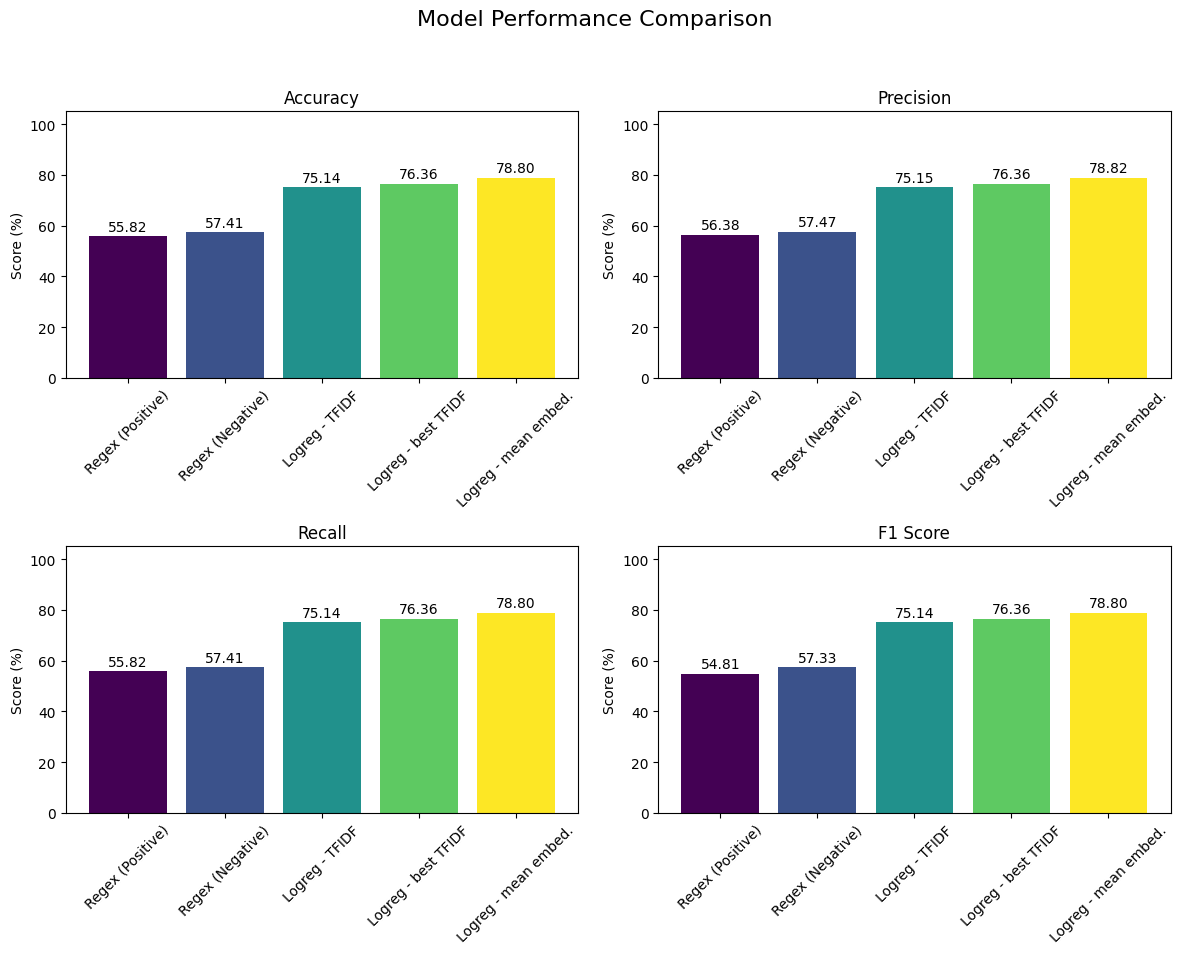

In [46]:
# Evaluate on the validation set
valid_preds = best_model.predict(embeddings_val_mean)

# Compute the metrics for the logistic regression model and the validation set
metrics_val.run(
    y_true=df_val['label'].values,
    y_pred=valid_preds,
    method_name="Logreg - mean embed.",
    average=metric_avg
)

metrics_val.plot()

As can be observed in the plot above, performance is slightly improved across all metrics with the mean embeddings from the Word2Vec model, applied to the reviews data. However, the increase in performance is still marginal, which could be attributed to 2 main reasons:
1. Through this method, all of the words in a review are given the same relevance (regardless of their rarity or frequency in the sentences). This approach is explored in the next question.
2. The lack of dynamic embeddings (instead of static), i.e., that all words have the same representation in all reviews even if the surrounding context is different. This can be especially problematic in this case, given that (as explored above) some film reviews use metaphores or are ironic, which can make static embeddings struggle significantly.

### b. Create sentence embeddings using TF-IDF weighted averages of word vectors and retrain the model. Compare this approach with the mean embedding technique. Comment.

The approach that is used here is the same as in the previous question, but in this case, and within each review, each word embedding is weighted by the TF-IDF weight for that word.

The function `word2vec_tfidf_weighted_embedding`, used below:
1. Processes all texts and gets their TF-IDF weights using the provided (fitted) vectorizer. Note that, to fit the TF-IDF matrix and pass it into the function `word2vec_tfidf_weighted_embedding`, the input can only be the pre-processed text with no stopwords and lowercased.
2. For each text, it finds which words have TF-IDF weights and are in the Word2Vec model
3. It multiplies each word vector by its corresponding TF-IDF weight
4. It computes the weighted average by summing the weighted vectors and dividing by the total weight
5. If no weighted vectors are found, it returns a zero vector

In [ ]:
# First, we fit the TF-IDF vectorizer on the training data
tfidf_vectorizer = TfidfVectorizer(
    lowercase=False,  # Already preprocessed in lower_nostop
    stop_words=None,  # Already handled in lower_nostop
    min_df=0.0,
    max_df=1.0,
    sublinear_tf=True,  # Apply sublinear term frequency scaling
    ngram_range=(1, 1)  # Unigrams only
)
# Fit the TF-IDF vectorizer on the training data with the text
tfidf_vectorizer.fit(df_train['text_lower'].values)

# Then create the TF-IDF weighted embeddings
embeddings_train_tfidf_mean = preprocessing.word2vec_tfidf_weighted_embedding(
    df_train['text'], 
    word2vec_model, 
    tfidf_vectorizer, 
    rm_stopwords=True, 
    stopwords=my_stop_words
)

embeddings_val_tfidf_mean = preprocessing.word2vec_tfidf_weighted_embedding(
    df_val['text'], 
    word2vec_model, 
    tfidf_vectorizer, 
    rm_stopwords=True, 
    stopwords=my_stop_words
)

# Check the shape of the sentence embeddings
print(f"Shape of the sentence embeddings for training set: {embeddings_train_tfidf_mean.shape}")  # Should be (num_reviews, 300)
print(f"Shape of the sentence embeddings for validation set: {embeddings_val_tfidf_mean.shape}")  # Should be (num_reviews, 300)

Shape of the sentence embeddings for training set: (8530, 300)
Shape of the sentence embeddings for validation set: (1066, 300)


In [51]:
# Fit the randomized search defined in the previous section on the training data, 
random_search.fit(embeddings_train_tfidf_mean, df_train['label'].values)

# Best parameters found by grid search
print(f'Best Parameters: {random_search.best_params_}')

# Save the best model as a pickle file with the name of the model and the F1 score in the models directory
os.makedirs('models', exist_ok=True)
best_model_name = f"models/word2vec_tfidf_weighted_emb_f1_{metric_avg}_{random_search.best_score_:.4f}.pkl"
with open(best_model_name, 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)
print(f"Best model saved as: {best_model_name}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': 0.5741157902710026, 'penalty': 'l2'}
Best model saved as: models/word2vec_tfidf_weighted_emb_f1_macro_0.7650.pkl


For 50 iterations and 5 folds, it takes approximately 2.33 minutes to finish the `RandomizedSearchCV`.

In [53]:
# Load the best model from the pickle file
with open('models/word2vec_tfidf_weighted_emb_f1_macro_0.7650.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Train the best model on the entire training set
model = best_model.fit(embeddings_train_tfidf_mean, df_train['label'].values)

model

LogisticRegression(C=0.5741157902710026, max_iter=1000, random_state=42,
                   solver='liblinear')

Metrics calculated for: Logreg - tfidf embed.


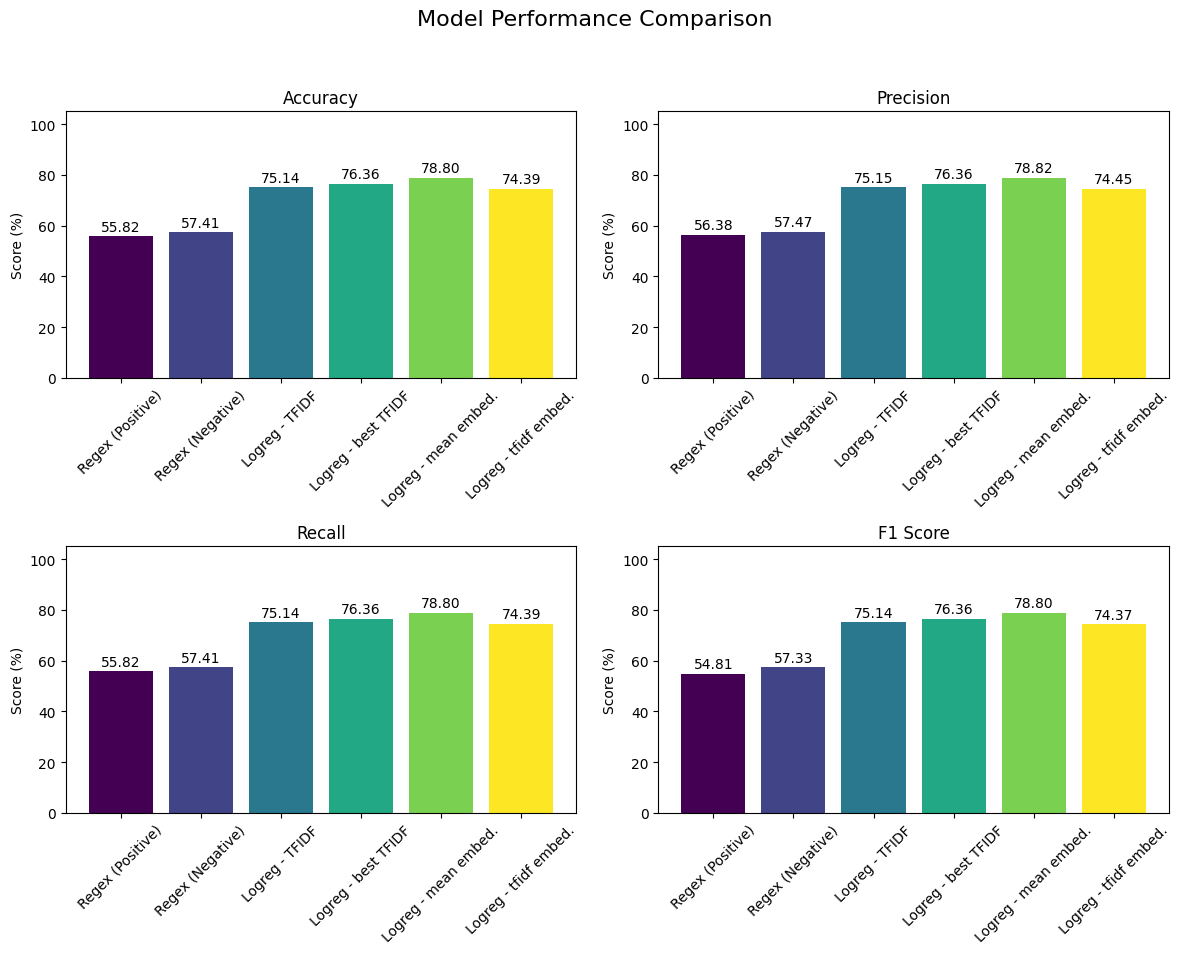

In [54]:
# Evaluate on the validation set
valid_preds = best_model.predict(embeddings_val_tfidf_mean)

# Compute the metrics for the logistic regression model and the validation set
metrics_val.run(
    y_true=df_val['label'].values,
    y_pred=valid_preds,
    method_name="Logreg - tfidf embed.",
    average=metric_avg
)

metrics_val.plot()

A bit surprisingly, the logistic regression with the TF-IDF-weighted word embeddings performs worse than with simple (arithmetic) mean embeddings for each text. Given how TF-IDF works, emphasizing rare words which appear in few documents (and downweighting the others), it may be that it is precisely downweighting more common words which can be closely linked to the sentiment, which could lead to this relatively worse performance.

# 3. Part 3: Recurrent Neural Networks (RNN) with Word2Vec (4 points)

**Objective**: Explore the application of RNNs for sentiment analysis, utilizing pre-trained Word2Vec embeddings.

## 3.1. RNN Implementation

(1 point for each section)

### a. Fit an RNN model with LSTM units using Word2Vec embeddings. Analyze and compare its performance with the TF-IDF based logistic regression model. 

(1 point)

#### Preprocessing for the LSTM

(Following the guidelines in the notebooks `Session_2_3_LSTM_Classif.ipynb` and `Session_4_correction.ipynb`).

In [ ]:
vocab_size = 20000  # Maximum size of the vocabulary

# Initialize and fit the tokenizer (create word IDs), and create ID for out-of-vocabulary words 
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text'].values)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Convert texts to sequences of word IDs (transform)
sequences_train = tokenizer.texts_to_sequences(df_train['text'].values)
sequences_val = tokenizer.texts_to_sequences(df_val['text'].values)

# Print an example
print('\nOriginal text:\n')
print(df_train['text'][0])
print('\nWord IDs:\n')
print(sequences_train[0])
print('\nTokenized text:\n')
print(tokenizer.sequences_to_texts([sequences_train[0]]))

Found 17452 unique tokens.

Original text:

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .

Word IDs:

[2, 645, 7, 2775, 6, 21, 2, 3217, 8963, 94, 4801, 4, 9, 313, 230, 6, 68, 3, 3218, 53, 2431, 34, 1480, 1961, 1962, 8964, 1481, 6231, 39, 939, 8965]

Tokenized text:

["the rock is destined to be the 21st century's new conan and that he's going to make a splash even greater than arnold schwarzenegger jean claud van damme or steven segal"]


In [ ]:
max_length = 64  # Maximum length of the sequences (number of words in a review). Set to 64 because, at most, reviews have 59 words (see 0.2) 

# Pad sequences to the same length (i.e., truncate longer sequences by not considering 
# the words further than the maximum length and pad shorter ones, by adding zeros at the end)
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_length,
                                 padding='post', truncating='post')
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_length,
                                 padding='post', truncating='post')

# Convert labels to numpy arrays
y_train = df_train['label'].values
y_val = df_val['label'].values

#### Create embedding metrix from Word2Vec

The embedding layer with the pre-trained Word2Vec model from `gensim` is created here.

In [67]:
# Create embedding matrix using pre-trained Word2Vec
embedding_matrix = np.zeros((len(word_index) + 1, word_vector_dim))  # Sum 1 for the out-of-vocabulary token

for word, i in word_index.items():
    if i < vocab_size:
        try:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Word not in embedding model, leave as zeros
            continue

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (17453, 300)


#### Build the model

In [89]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,  # Vocabulary size + 1 for out-of-vocabulary token
                    word_vector_dim,  # Dimension of the word vectors (300 for Google News model)
                    weights=[embedding_matrix],  # Pre-trained word vector weights
                    trainable=False))  # Set to False to avoid fine-tuning embeddings

# Add LSTM layer(s)
model.add(Bidirectional(LSTM(
    64,  # Number of LSTM units
    return_sequences=True,  # Return the full sequence for the next LSTM layer (which preserves the sequential nature of the data)
    dropout=0.2,  # Dropout for the LSTM layer to prevent overfitting
    recurrent_dropout=0.2,
    activity_regularizer=l2(0.01)  # L2 regularization to prevent overfitting
)))

# Flatten layer to convert 3D output to 2D
model.add(Flatten())

# Add dropout before the dense layer to prevent overfitting
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, # Number of classes (1 for binary classification)
                activation='sigmoid'  # Sigmoid activation for binary classification
))

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     5,235,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,235,900 (19.97 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,235,900 (19.97 MB)

#### Train the model

In [ ]:
# Setup early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # How many epochs to wait after min has been hit
    verbose=1,  # Verbosity level
    mode='min',  # Mode for the monitored quantity (minimizing loss)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train model
history = model.fit(padded_sequences_train, 
                    y_train,
                    epochs=50,  # Number of epochs to train
                    batch_size=64,
                    validation_data=(padded_sequences_val, y_val),
                    callbacks=[early_stopping])

# Save the model with accuracy in name
best_val_acc = max(history.history['val_accuracy'])
model_dir = f'models/lstm_word2vec_val_acc_{best_val_acc:.4f}.keras'
model.save(model_dir)
print(f"Model saved to: {model_dir}")

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5905 - loss: 3.1717 - val_accuracy: 0.6857 - val_loss: 0.8397
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6984 - loss: 0.8958 - val_accuracy: 0.6998 - val_loss: 0.7193
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7312 - loss: 0.7336 - val_accuracy: 0.7552 - val_loss: 0.6128
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7469 - loss: 0.6336 - val_accuracy: 0.7589 - val_loss: 0.5749
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7580 - loss: 0.5878 - val_accuracy: 0.7580 - val_loss: 0.5522
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7650 - loss: 0.5555 - val_accuracy: 0.7439 - val_loss: 0.5569
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7658 - loss: 0.5437 - val_accuracy: 0.7739 - val_loss: 0.5145
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7800 - loss: 0.5188 - val_accu

#### Visualization of the training process

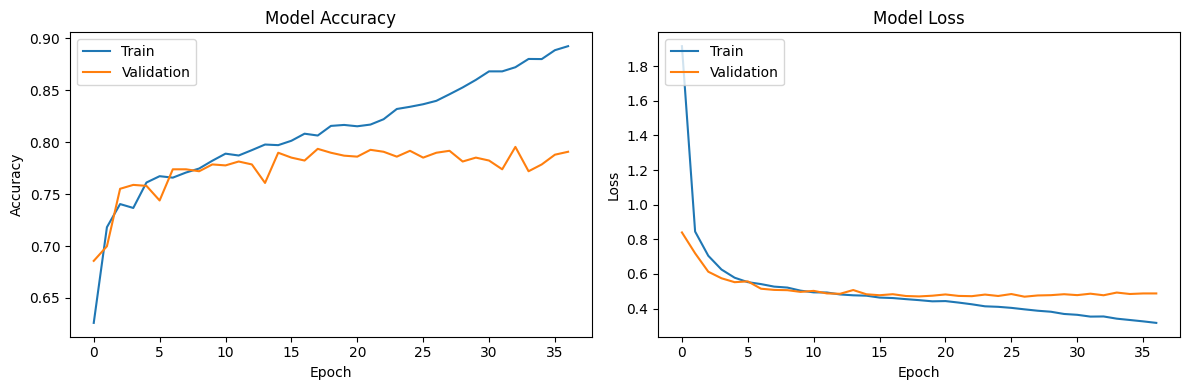

In [91]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Clearly, the model starts overfitting the training set after just a few epochs.

#### Evaluation of the model and comparison

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Metrics calculated for: LSTM - Word2Vec


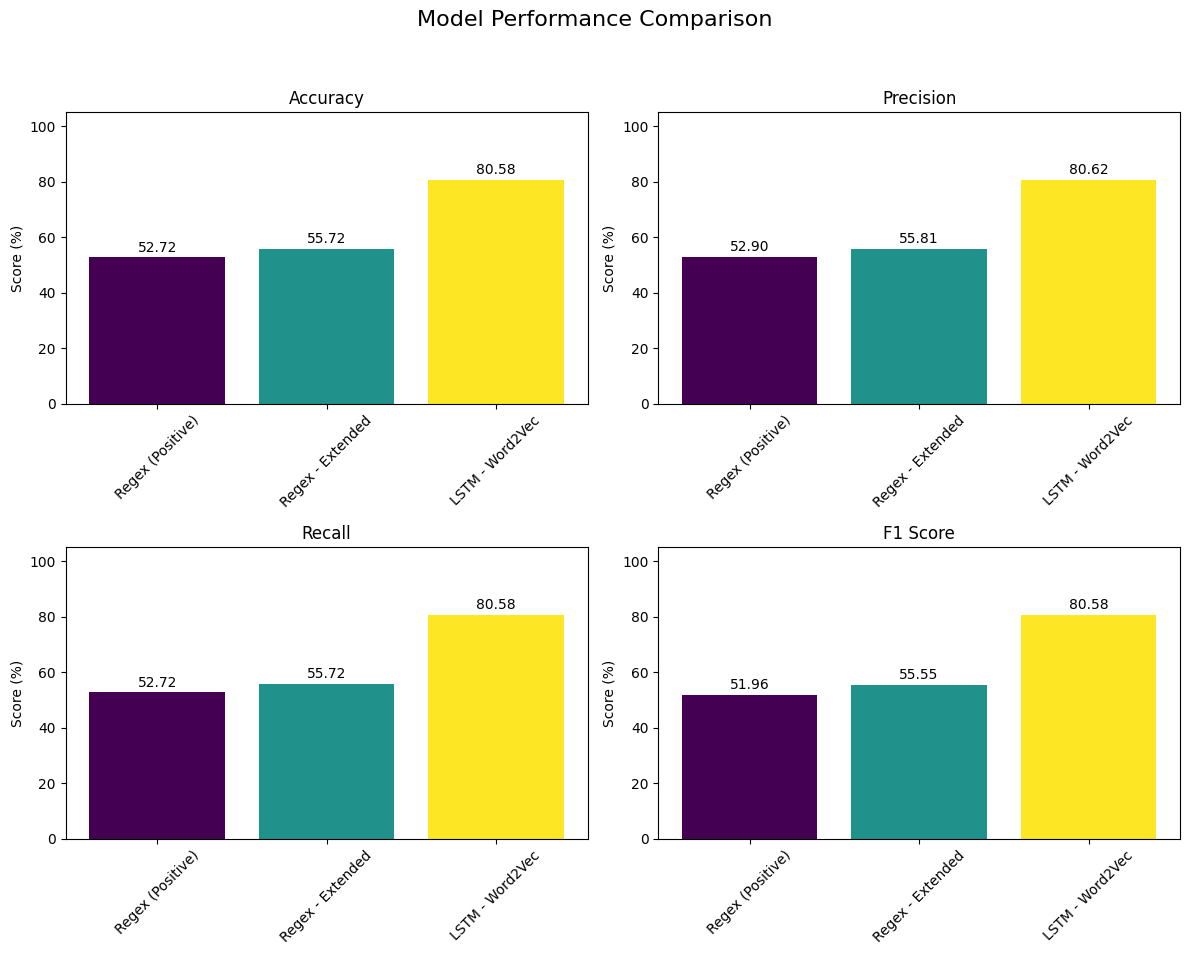

In [94]:
# Evaluate on test set
sequences_test = tokenizer.texts_to_sequences(df_test['text'].values)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length,
                                 padding='post', truncating='post')
y_test = df_test['label'].values

test_preds_proba = model.predict(padded_sequences_test)
test_preds = (test_preds_proba > 0.5).astype(int).flatten()

# Compute metrics and compare with previous models
metrics_test.run(
    y_true=y_test,
    y_pred=test_preds,
    method_name="LSTM - Word2Vec",
    average=metric_avg
)
metrics_test.plot()

### b. Discuss any notable differences in results.

(1 point)

In this case, the performance has been evaluated on the test set (as the validation set has been used for validation in the training stage). As shown in the plot above (and compared to the plot at the end of section 2.4), it can be observed that performance is improved compared to the logistic regression with the mean of the embeddings. This denotes that the bi-directional LSTM is more capable to capture the intricacies of the text data, which can be probably attributed to the fact that it is capable to capture better word sequences (which was not considered before with logistic regression).

Nevertheless, the performance has only marginally improved (it is not a big leap compared to the models of part 2). Again, a possible reason for this is that the context is not captured dynamically in each review passed to the model. 

## 3.2. Word2Vec Vectors Analysis 

(1 point for each section)

### a. Before and After Fine-Tuning

(1 point): Examine the evolution of word vectors by comparing them before and after fine-tuning on the movie review dataset. Provide insights into the changes observed.

Again, we need to train the LSTM, but this time allowing for changes in the weights of the Word2Vec embeddings.

#### Create a model with trainable embeddings

In [97]:
# First, we save a copy of the original pre-trained embeddings
original_embeddings = embedding_matrix.copy()

# Create a new model with trainable embeddings
model_tuned = Sequential()
model_tuned.add(Embedding(len(word_index) + 1,  
                        word_vector_dim,
                        weights=[embedding_matrix],  
                        trainable=True))  # Set to True to enable fine-tuning

# Add LSTM layer(s) - same as before
model_tuned.add(Bidirectional(LSTM(
    64,
    return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    activity_regularizer=l2(0.01)
)))

# Flatten layer
model_tuned.add(Flatten())
model_tuned.add(Dropout(0.2))

# Output layer
model_tuned.add(Dense(1, activation='sigmoid'))

# Compile model
model_tuned.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#### Train the model with fine-tuning

In [ ]:
# Train with early stopping
history_tuned = model_tuned.fit(
    padded_sequences_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(padded_sequences_val, y_val),
    callbacks=[early_stopping]
)

# Save the model with accuracy in name
best_val_acc = max(history_tuned.history['val_accuracy'])
model_tuned_dir = f'models/lstm_word2vec_tuned_val_acc_{best_val_acc:.4f}.keras'
model_tuned.save(model_tuned_dir)
print(f"Model saved to: {model_tuned_dir}")

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5885 - loss: 4.0722 - val_accuracy: 0.7101 - val_loss: 0.8273
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7239 - loss: 0.8848 - val_accuracy: 0.7233 - val_loss: 0.7163
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7882 - loss: 0.7314 - val_accuracy: 0.7552 - val_loss: 0.6530
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8527 - loss: 0.6036 - val_accuracy: 0.7420 - val_loss: 0.6758
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9233 - loss: 0.4395 - val_accuracy: 0.7552 - val_loss: 0.5901
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9639 - loss: 0.3121 - val_accuracy: 0.7486 - val_loss: 0.6070
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9789 - loss: 0.2394 - val_accuracy: 0.7467 - val_loss: 0.6144
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9875 - loss: 0.1922 - val_acc

#### Extract and compare the embeddings

In [103]:
# Extract the fine-tuned embeddings from the model
tuned_embedding_layer = model_tuned.layers[0]
tuned_embeddings = tuned_embedding_layer.get_weights()[0]

# Select some interesting words to compare (sentiment-related vocabulary)
words_to_analyze = ['good', 'great', 'excellent', 'bad', 'terrible', 'movie', 'film', 'actor', 'boring']

print("Comparing original vs fine-tuned embeddings:")
print("-" * 50)

for word in words_to_analyze:
    if word in tokenizer.word_index:
        idx = tokenizer.word_index[word]
        if idx < vocab_size:
            # Calculate cosine similarity between original and tuned vectors
            orig_vec = original_embeddings[idx]
            tuned_vec = tuned_embeddings[idx]
            
            # Normalize vectors
            orig_norm = np.linalg.norm(orig_vec)
            tuned_norm = np.linalg.norm(tuned_vec)
            
            if orig_norm > 0 and tuned_norm > 0:
                # Calculate cosine similarity
                similarity = np.dot(orig_vec, tuned_vec) / (orig_norm * tuned_norm)
                
                # Calculate Euclidean distance
                distance = np.linalg.norm(orig_vec - tuned_vec)
                
                print(f"Word: '{word}'")
                print(f"  Cosine similarity: {similarity:.4f}")
                print(f"  Vector distance: {distance:.4f}")
                print(f"  Change magnitude: {distance/orig_norm:.4f}")
                print("-" * 30)

Comparing original vs fine-tuned embeddings:
--------------------------------------------------
Word: 'good'
  Cosine similarity: 0.9474
  Vector distance: 0.7183
  Change magnitude: 0.3202
------------------------------
Word: 'great'
  Cosine similarity: 0.9659
  Vector distance: 0.6100
  Change magnitude: 0.2601
------------------------------
Word: 'excellent'
  Cosine similarity: 0.9796
  Vector distance: 0.5156
  Change magnitude: 0.2008
------------------------------
Word: 'bad'
  Cosine similarity: 0.9452
  Vector distance: 0.8229
  Change magnitude: 0.3268
------------------------------
Word: 'terrible'
  Cosine similarity: 0.9743
  Vector distance: 0.5918
  Change magnitude: 0.2327
------------------------------
Word: 'movie'
  Cosine similarity: 0.9540
  Vector distance: 0.8033
  Change magnitude: 0.3013
------------------------------
Word: 'film'
  Cosine similarity: 0.9414
  Vector distance: 0.8935
  Change magnitude: 0.3379
------------------------------
Word: 'actor'
  Cos

### b. Visualization and Commentary

(1 point): Visualize the embeddings of select words before and after fine-tuning using a tool like t-SNE or PCA. Comment on any patterns or shifts in word associations.